# Taxonomic Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from tqdm import tqdm_notebook

from collections import Counter

from statistics import stdev, mean

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pickle

import time
import os
import subprocess as subp
import re

from scipy import stats
from statsmodels.stats import multitest

from skbio.stats.composition import ilr, clr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import random as rand

## Functions

In [2]:
def DataTrans(df):
    """
    Function to conduct CLR transformation on given data
    
    Parameters
    ----------
    df: Dataframe containing the data for transformation
    
    Returns
    -------
    Dataframe with log-ratio transformed data
    """
    
    wdf = df.drop("Group", axis=1).copy().fillna(0) #Working DF
    
    #Replace 0's with very small numbers
    trans_df = wdf.set_index("SampleName").apply(lambda x:x.replace(0, 1e-10))
    
    #Tranform the data and turn into a DF
    clr_df = pd.DataFrame(clr(trans_df),\
                      columns=list(trans_df.columns),\
                      index=list(trans_df.index.values))

    #Add the group labels
    clr_df = clr_df.join(df.set_index("SampleName").Group)
    return clr_df

In [7]:
def DrawPCA(df, save, dpi=200, plot_title=None, out=False, loadings=False, color_pal=None, order_list=None):
    """
    Function to draw PCA using the given data
    
    Paramters
    ---------
    df: Transformed dataframe
    plot_title: String to be title of plot
    save: Boolean to save the image
    dpi: Integer specifying dpi of saved image
    out: String to save the image as
    loadings: Boolean to determine if contributions to Component 1 are displayed
    color_pal: Name of Seaborn color palette
    order_list = list of the order to color the groups (diseased should be in the front)
    
    Returns
    -------
    Image of PCA
    Series of loadings (optional)
    """
    
    trans_df = df.copy()
    
    #Split the data up for the PCA
    xp = trans_df.drop("Group", axis=1).values
    yp = trans_df.Group.values

    #Fit the PCA
    pca = PCA(n_components=10)
    trans_pca = pca.fit_transform(xp)

    #Store the values in a DF for future use
    global pcdf
    pcdf = pd.DataFrame(data=trans_pca.T[:5].T, columns=["PC1", "PC2", "PC3", "PC4", "PC5"],\
                       index= list(trans_df.index))
    pcdf["Group"] = yp

    #Extract the explained variances
    pc1_var = round(pca.explained_variance_ratio_[0]*100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1]*100, 2)

    #Graph the PCA
    #Create a color palette
    sc = ["#ff0000", "#70b9fd", "#ffd3d9", "#FF8B00", "#FF70BC",\
          "#ffffff", "#c97ec9", "#00ea04", "#4230ff", "#000000"]
    scp = sns.color_palette(sc)
    scp2 = scp[:len(np.unique(yp))]
    
    if color_pal == None:
        color_pal = scp2
        
    plt.figure(figsize=(10,6))
    
    sns.scatterplot(data=pcdf.sort_values(by="Group"), x='PC1', y='PC2', hue='Group', hue_order = order_list, legend='full',\
                    linewidth=0.7, edgecolor='black', palette=color_pal, zorder=1, alpha=0.7)
    
    centroids = pcdf.sort_values(by="Group").groupby("Group").describe()["PC1"][["mean", "std"]]\
.join(pcdf.groupby("Group").describe()["PC2"][["mean", "std"]], lsuffix="1", rsuffix="2")
    
    centroids["Group"] = centroids.index.values
    sns.scatterplot(data=centroids, x="mean1", y="mean2", hue="Group",\
                   legend=False, palette=color_pal, marker="D", s=100, alpha=1, zorder=2,\
                   linewidth=4, edgecolor='k')
    
    if not plot_title:
        pass
    else:
        plt.title(plot_title+"\n", weight='bold')

    plt.xlabel('PC 1 ({} %)'.format(pc1_var))
    plt.ylabel('PC 2 ({} %)'.format(pc2_var))

    plt.legend(frameon=True, edgecolor='black', facecolor='#dddddd',\
              bbox_to_anchor=(1, 1), loc="upper left")
    
    if loadings:
        cdf = pd.DataFrame(pca.components_,columns=trans_df.drop("Group", axis=1).columns)
        cdct = dict(cdf.loc[0])
        comp1 = pd.DataFrame.from_dict(cdct, orient='index', columns=["Component1"])
        comp1["abs"] = abs(comp1.Component1)
        comp1.sort_values(by="abs", ascending=False, inplace=True)
        return comp1.drop("abs", axis=1)
    
    plt.tight_layout()
    
    if save:
        if out == None:
            print("Please specifiy an 'out' string as a name")
        else:
            plt.savefig(out, dpi=dpi)
            print("File saved as '{}'".format(out))

In [8]:
def RFC_FI(trans_df, n, top_model_name, save, top_n=20, out=False, dpi=200):
    """Function to run a random forest classifier on transformed data n times and find the feature importances
    
    Paramters
    ---------
    trans_df: Dataframe containing transformed data
    n: Integer specifying how many times to re-run the classifier
    top_model_name: String specifying name to save the top-performing model as (without suffix)
    top_n: Integer specifying the top-n feature importances to show
    save: Boolean specifying whether to save the image or not
    out: String to save image as
    dpi: Integer specifying dpi of saved image
    
    Returns
    -------
    F-1 Scores for each run
    Image for top-n feature importances
    Importances returned as a global dataframe named 'imps'
    F1-scores for every run stored in a global dict named 'totals'
    
    """
    
    from sklearn.preprocessing import LabelEncoder
    from collections import defaultdict
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier as rfc
    
    d = defaultdict(LabelEncoder)
    
    edf = trans_df.dropna().apply(lambda x: d[x.name].fit_transform(x)) #Encoded DF

    x = edf.drop(["Group"], axis=1)
    y = edf.Group.values
    
    xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3)
    
    #Create dictionaries to hold the values for Group f-1 scores
    a_runs = {} #Runs for group a; contains F-1 scores
    b_runs = {} #Runs for group b; contains F-1 scores

    global totals
    totals = {0:0}

    runs = 0

    #START LOOP

    print("Starting RFC\n")
    
    time0 = time.time()
    
    for i in range(n):
        runs +=1
        time1 = time.time()

        rf = rfc(n_estimators=500, oob_score=True)
        rf.fit(xtrain, ytrain)
        predicts = rf.predict(xtest)

        a_runs[i] = (classification_report(ytest, predicts).split(sep="      "))[6].strip()
        b_runs[i] = (classification_report(ytest, predicts).split(sep="      "))[11].strip()

        s = rf.score(xtest, ytest)

        if s > max(totals.values()) :
            pickle.dump(rf, open(top_model_name+'.sav', 'wb'))

        totals[i] = s

        print(" Run {} Completed -- Score = {} -- TimeForLoop = {} seconds".format(
            runs, s, round((time.time() - time1),4)), end="\r")

    #END LOOP
    print("\nRFC Complete. Top model saved as '{}.sav'.".format(top_model_name))
    
    #Find feature importances
#     global rf1
    rf1 = pickle.load(open(top_model_name+'.sav', 'rb')) #Load the highest performing classifier

    #Create a dataframe that houses the feature importances
    global imps
    imps = pd.DataFrame(rf1.feature_importances_, columns=['Importance'], index=xtrain.columns)
    imps.sort_values('Importance', ascending=False, inplace=True)
    imps.Importance = imps.Importance*100
    imps.rename(columns={'Importance':'Importance %'}, inplace=True)
    new_labels = []
    for i in imps.index:
        new_labels.append("\n\n\n"+i.replace("_strain", "\nstrain_"))
    imps["GraphLabels"] = new_labels
    
    print(f"Top scoring model F1-score: {round(np.max(list(totals.values())), 3)}")


    imps.set_index("GraphLabels")[:top_n].plot(kind='bar', legend=False, figsize=(20,16),\
                      color='gold', linewidth=0.7, edgecolor='k')
    plt.title('Top-{} Feature Importances\n'.format(top_n), size=22)
    plt.xlabel('\nFeature Name', size=15)
    plt.ylabel('Percent Feature Importances\n', size=17)
    plt.yticks(size=15)
    plt.xticks(rotation=45, ha='right', size=17)
    plt.tight_layout()
    
    if save:
        if out:
            plt.savefig(out, dpi=dpi)
            print("Image saved as {}".format(out))
        else:
            print("No image name specified in 'out' variable. No image saved!")
            
    
    print("\n"+60*"-")
    global class_report
    class_report = classification_report(ytest, predicts, target_names=list(d['Group'].classes_))
    print(class_report)
    print(60*"-", "\n")
        
    plt.show()

## Analysis

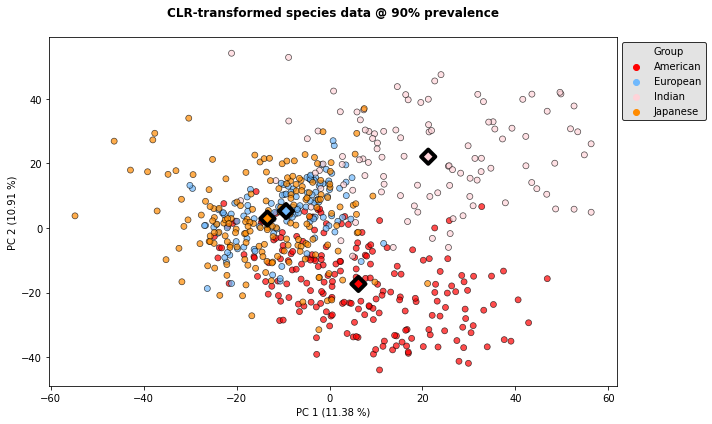

In [9]:
udf = pd.read_csv("DataFiles/allCohorts_90PrevSpecies.csv").rename(columns={"Cohort":"Group"})
uclr = DataTrans(udf)

DrawPCA(uclr, save=False, out=np.nan, dpi=200,\
       plot_title="CLR-transformed species data @ 90% prevalence", loadings=False)

In [15]:
# Run the RFC and store feature importances
# RFC_FI(uclr, n=50, top_model_name="CoreUnion5Test",\
#        top_n=10, save=False)


# Save totals to a csv
# pd.DataFrame.from_dict(totals, orient='index', columns=["F1-Score"]).to_csv("totals.csv")

# Save imps to a csv
# imps.to_csv("imps.csv")

# Network analysis

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from tqdm.notebook import tqdm as tqdm_nb

import os
import re

## Functions

In [28]:
def MakeNet(F, thresh=0.01):
    """
    Function to make the network within the notebook
    
    Parameters
    ----------
    F: File path
    
    Returns
    -------
    nx.Graph object
    
    """

    # Import matrix
    try:
        df = pd.read_csv(F, index_col="Unnamed: 0")
    except:
        try:
            df = pd.read_csv(F, index_col="Names")
        except:
            df = pd.read_csv(F)


    # Fix the names to fit in the nodes
#     new_names = list(df.apply(lambda x:x.name.replace("_", "\n")).values)

#     df["Index"] = new_names
#     df.set_index("Index", inplace=True)
#     df.columns =  new_names

    # Create an empty graph
    G = nx.Graph()

    # Iterate through the data to extract the nodes, edges, and weights
    for n1 in df.columns:
        for n2 in df.index:
            if abs(df.loc[n2,n1]) >= thresh and n2 != n1:
                if abs(df.loc[n2,n1]) != 0:
                    # Add weighted edge (wt) between node1 (n1) and node2 (n2)
                    G.add_edge(n1,n2, weight = df.loc[n2,n1])
                    
    print(f"{F.split('_')[0]}: N: {len(G.nodes)} E:{len(G.edges)}")
    return G

In [34]:
def ViewTops(G, top_list, print_neighbors=False):
    """
    Function to find the average edge weights of the top_list of nodes compared to other nodes
    
    Parameters
    ----------
    G: nx.Graph object
    top_list: list of nodes
    print_neighbors: Boolean to print out each node name and it's number of direct neighbors
    
    Returns
    -------
    Print-outs
    
    """
    
    weights = []
    non_weights = []
        
    for n in G.nodes:
        if print_neighbors:
            # Make the print out nicer
#             n = n.replace("\n", "_")
            string = f"{n} neighbors"
            print("-" * len(string))
            print(string)
            print("-" * len(string))

        # Correct the node names    
#         n = n.replace("_", "\n")

        # Extract the neighbors
        try:
#             print("Node: " + n.replace("\n", "_") + " neighbors: " + str(len(G[n])))
            for k,v in G[n].items():
                if n in top_list:
                    if print_neighbors:
#                         k = k.replace("\n", "_")
                        print(f"{k}: {v}")
                    else:
                        weights.append(v["weight"])
                else:
                    non_weights.append(v["weight"])
        except KeyError:
            pass
        
        
    deg_df = pd.DataFrame.from_dict(dict(G.degree), orient='index', columns=["degree"])
    found = {} # {node:degree}
         
    # Correct the node names
    for n in top_list:
        # Extract the degrees
        try:
            found[n] = int(deg_df.loc[n])
            
        except KeyError:
            pass
    
    # avg degree of non-top list nodes
    non_avg = deg_df.loc[[x for x in deg_df.index if x not in found]].degree.mean()
        
    results_cols = ["Group", "Average edge weight", "Average degree"]
    results = [["Conserved", round(np.mean(weights), 4), round(np.mean(list(found.values())), 3)],
              ["Non-conserved", round(np.mean(non_weights), 4), round(non_avg, 3)]]
    
    # Print the results
    from tabulate import tabulate
    print(tabulate(results, headers=results_cols))
        
#     print(f"{len(weights)} nodes are directly connected to top-nodes")
#     print(f"Average edge weight of top nodes: {round(np.mean(weights), 4)}")
    
#     print(f"{len(non_weights)} nodes are NOT directly connected to top-nodes")
#     print(f"Average edge weight of non-top nodes: {round(np.mean(non_weights), 4)}")

## Analysis

In [32]:
amerG = MakeNet("DataFiles/american_90_clr_resultsPCorBootOmega.csv")
euroG = MakeNet("DataFiles/european_90_clr_resultsPCorBootOmega.csv")
japnG = MakeNet("DataFiles/japanese_90_clr_resultsPCorBootOmega.csv")
indnG = MakeNet("DataFiles/indian_90_clr_resultsPCorBootOmega.csv")

GraphsDict = {"European":euroG, "Indian":indnG, "HMP":amerG, "Japanese":japnG}

american: N: 97 E:338
european: N: 149 E:386
japanese: N: 117 E:274
indian: N: 104 E:273


In [35]:
# Import the top-20 FI's
df20 = pd.read_csv("DataFiles/Top20_FI_list.csv")
top_20 = list(df20[df20.ID == "Top-20 FI"]["Bacteria"])


title = "Top-20 FI nodes"
print("=" * (len(title)+1))
print(title)
print("=" * (len(title)+1))

for g in GraphsDict:
    
    print("\n")
    string = f"{g} network"
    print(string)
    print("-" * (len(string)+1))
    
    ViewTops(GraphsDict[g], top_20)

Top-20 FI nodes


European network
-----------------
Group            Average edge weight    Average degree
-------------  ---------------------  ----------------
Conserved                     0.077              3.214
Non-conserved                 0.0686             5.385


Indian network
---------------
Group            Average edge weight    Average degree
-------------  ---------------------  ----------------
Conserved                     0.0851             3
Non-conserved                 0.0702             5.489


HMP network
------------
Group            Average edge weight    Average degree
-------------  ---------------------  ----------------
Conserved                     0.0582             5.667
Non-conserved                 0.0533             7.102


Japanese network
-----------------
Group            Average edge weight    Average degree
-------------  ---------------------  ----------------
Conserved                     0.0727             2.786
Non-conserved                

# Functional analysis

## Functions

In [40]:
def DrawPCA(df, var, save=False, dpi=200, plot_title=None, out=False, loadings=False, color_pal=None, order_list=None):
    """
    Function to draw PCA using the given data
    
    Paramters
    ---------
    df: Transformed dataframe
    var: Variable of interest
    plot_title: String to be title of plot
    save: Boolean to save the image
    dpi: Integer specifying dpi of saved image
    out: String to save the image as
    loadings: Boolean to determine if contributions to Component 1 are displayed
    color_pal: Name of Seaborn color palette
    order_list = list of the order to color the groups (diseased should be in the front)
    
    Returns
    -------
    Image of PCA
    Series of loadings (optional)
    """
    
    # Import the neccessary modules
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    trans_df = df.copy()
    
    #Split the data up for the PCA
    xp = trans_df.drop(var, axis=1).values
    yp = trans_df[var].values

    #Fit the PCA
    pca = PCA(n_components=10)
    trans_pca = pca.fit_transform(xp)

    #Store the values in a DF for future use
    global pcdf
    pcdf = pd.DataFrame(data=trans_pca.T[:5].T, columns=["PC1", "PC2", "PC3", "PC4", "PC5"],\
                       index= list(trans_df.index))
    pcdf[var] = yp

    #Extract the explained variances
    pc1_var = round(pca.explained_variance_ratio_[0]*100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1]*100, 2)

    #Graph the PCA
    #Create a color palette
    sc = ["#ff0000", "#70b9fd", "#ffd3d9", "#FF8B00", "#FF70BC",\
          "#ffffff", "#c97ec9", "#00ea04", "#4230ff", "#000000"]
    scp = sns.color_palette(sc)
    scp2 = scp[:len(np.unique(yp))]
    
    if color_pal == None:
        color_pal = scp2
        
    plt.figure(figsize=(10,6))
    
    sns.scatterplot(data=pcdf.sort_values(by=var), x='PC1', y='PC2', hue=var, hue_order = order_list, legend='full',\
                    linewidth=0.7, edgecolor='black', palette=color_pal, zorder=1, alpha=0.7)
    
    centroids = pcdf.sort_values(by=var).groupby(var).describe()["PC1"][["mean", "std"]]\
.join(pcdf.groupby(var).describe()["PC2"][["mean", "std"]], lsuffix="1", rsuffix="2")
    
    centroids[var] = centroids.index.values
    sns.scatterplot(data=centroids, x="mean1", y="mean2", hue=var,\
                   legend=False, palette=color_pal, marker="D", s=100, alpha=1, zorder=2,\
                   linewidth=4, edgecolor='k')
    
    if not plot_title:
        pass
    else:
        plt.title(plot_title+"\n", weight='bold')

    plt.xlabel('PC 1 ({} %)'.format(pc1_var))
    plt.ylabel('PC 2 ({} %)'.format(pc2_var))

    plt.legend(frameon=True, edgecolor='black', facecolor='white')
              #bbox_to_anchor=(1, 1), loc="upper left")
    
    plt.tight_layout()
    
    if save:
        if out == None:
            print("Please specifiy an 'out' string as a name")
        else:
            plt.savefig(out, dpi=dpi)
            print("File saved as '{}'".format(out))
    
    if loadings:
        cdf = pd.DataFrame(pca.components_,columns=trans_df.drop(var, axis=1).columns)
        cdct = dict(cdf.loc[0])
        comp1 = pd.DataFrame.from_dict(cdct, orient='index', columns=["Component1"])
        comp1["abs"] = abs(comp1.Component1)
        comp1.sort_values(by="abs", ascending=False, inplace=True)
        return comp1.drop("abs", axis=1)

In [62]:
def FindStatDiff(df, Group1, Group2, alpha=0.05, diff_thresh=1, top_n=20, 
                 targets=None, save=False, out=None, dpi=200):
    """
    Function to find significant differences between the groups and display the log-ratios
    
    1) Determines if a sample is normally distributed and then conductes the appropriate pair-wise test.
        a) Mann-Whitney U test for non-parametric.
        b) Two-Sample T-test for parametric data.
    2) Visualizes difference in log-ratios
    
    
    Parameters
    ----------
    df: Dataframe containing the transformed data for both groups
    group1: name of group1 as it appears in the dataframe
    group2: name of group2 as it appears in the dataframe
    alpha: cut-off for p-value
    top_n: Integer of top differences to display (default: 20)
    targets: List of bacteria to focus on
    title_label: String for image title
    out: String containing the image name
    save: Boolean for saving the image
    dpi: Integer specifiying the image DPI
    
    Returns
    -------
    Image display (Top-n differencnes with q-val > alpha and diff > thresh)
    Saved image
    diff_df: fold-change DF containg only the significantly different Fold-Changes that are higher in Group1
    """
    
    # First required function: StatAnalysis
    def StatAnalysis(trans_df, group1, group2, alpha=0.05):
        """Function to find significant differences between the groups

        Determines if a sample is normally distributed and then conductes the appropriate pair-wise test.
        Mann-Whitney U test for non-parametric.
        Two-Sample T-test for parametric data.

        Parameters
        ----------
        df: Dataframe containing the transformed data for both groups
        group1: name of group1 as it appears in the dataframe
        group2: name of group2 as it appears in the dataframe
        alpha: cut-off for p-value

        Returns
        -------
        Dataframe containing the results
        """
        
        from scipy import stats
        from statsmodels.stats import multitest

        df = trans_df.copy()

        dct = {} #To store information and turn into DF at the end
        #dct[i] = group1_norm, group2_norm, pval

        #Test for normality using D'Agostino Omnibus test
        for i in tqdm_nb(df.drop("Group", axis=1), desc="Conducting statistical analysis testing"):

            try:
                if stats.normaltest(df[i][df.Group == group1])[1] > alpha:
                    n1 = "Parametric"
                else:
                    n1 = "Non-parametric"

                if stats.normaltest(df[i][df.Group == group2])[1] > alpha:
                    n2 = "Parametric"
                else:
                    n2 = "Non-parametric"
            except ValueError: # Not enough samples to properly conduct SkewTest
                n1,n2 = "Non-parametric", "Non-parametric"


            #Perform correct pair-wise analysis
            if n1 == "Non-parametric" or n2 == "Non-parametric":
                try:
                    pval = stats.mannwhitneyu(df[i][df.Group == group1].values,\
                                              df[i][df.Group == group2].values)[1]
                except ValueError:
                    pval = int(1)

            else:
                pval = stats.ttest_ind(df[i][df.Group == group1].values,\
                                       df[i][df.Group == group2].values)[1]


            #Store the data
            dct[i] = [n1, n2,\
                      df[i][df.Group == group1].mean(), df[i][df.Group == group2].mean(),pval]

        norm1 = "{}_dist".format(group1)
        norm2 = "{}_dist".format(group2)
        mean1 = "{}_mean".format(group1)
        mean2 = "{}_mean".format(group2)


        #Create the analysis dataframe
        adf = pd.DataFrame.from_dict(dct, orient="index",\
                                     columns=[norm1, norm2, mean1, mean2, "P_value"])

        #Perform FDR correction
        adf["Q_value"] = multitest.multipletests(adf.P_value, method="fdr_bh")[1]

        print("Total bacteria: {}".format(len(adf)))
        print("Total samples: {}\n".format(len(df)))

        print("P < 0.05: {}"\
          .format(len(adf[adf.P_value < 0.05])))

        print("Q < 0.05: {}"\
          .format(len(adf[adf.Q_value < 0.05])))

        return adf.sort_values(by="Q_value", ascending=True)
    
    def DiffViz(df, alpha=0.05, top_n=20, targets=None, out=None, save=False, dpi=200, df_out=False):
        """
        Function to calculate and visualize top-n differences between the log-ratio transformed data

        Paramters
        ---------
        df: Dataframe containing the statistical analysis
        alpha: q-value cut-off for significance
        top_n: Integer of 'top' differences to display (default: 20)
        targets: List of bacteria to focus on
        title_label: String for image title
        out: String containing the image name
        save: Boolean for saving the image
        dpi: Integer specifiying the image DPI
        df_out: Boolean to return the fold-change df

        Returns
        -------
        Image display (Top-n differencnes with q-val > alpha and diff > thresh)
        Saved image
        fc_df: fold-change DF containg only the significantly different Fold-Changes
        """

        wdf = df.copy() #working df


        ######################Create the diffs (log fold-change)#####################################
        #1: find the rows containing the means
        rm = re.compile("_mean")
        mean_list = list(filter(rm.search,list(wdf.columns)))

        g1, g2 = mean_list #Store the groups into variables for easy use

        #2: Find the differences
        wdf["Diff"] = wdf.apply(lambda x:x[g1] - x[g2]\
                                         if x[g1]-x[g2] != 0\
                                         else 0, axis=1)

        wdf["abs"] = abs(wdf["Diff"])
        wdf.sort_values(by='abs', ascending=False, inplace=True)
        wdf.drop("abs", axis=1, inplace=True)


    #     global fc_df # For trouble-shooting
        if targets:
            fc_df = wdf[wdf.Q_value < 0.05].loc[ctargs].sort_values(by="Diff")
            ctargs = []
            for t in targets:
                if t in wdf[wdf.Q_value < 0.05].index:
                    ctargs.append(t)
                else:
                    print(f"{t} not significantly different")
        else:
            fc_df = wdf[wdf.Q_value < 0.05].head(top_n)

        ##################Create the fold-change graph##############################################
        mask1 = fc_df.Diff > 0 #Higher in HMP -- Lower in IBD
        mask2 = fc_df.Diff < 0 #Lower in HMP -- Higher in IBD

        plt.figure(figsize=(22,20))
        plt.bar(fc_df.index[mask1], fc_df.Diff[mask1], color='green', edgecolor='black', linewidth=1)
        plt.bar(fc_df.index[mask2], fc_df.Diff[mask2], color='red', edgecolor='black', linewidth=1)

        #Draw the graph labels
        #name1 = g1.split("_")[0]
        #name2 = g2.split("_")[0]
        plt.title("Top-{} log-ratio differences of {} (green) vs {} (red)".format(top_n, g1, g2),\
                  size=20)
        plt.ylabel("Log Difference\n", size=22)

        #Remove the x-ticks
        plt.tick_params(axis='x', bottom=False, labelbottom=False)

        #Draw the labels and asterisks on the graph
        #Pos labels
        x = 0.2
        for i in fc_df[mask1].index:
            s = i.replace("_strain", "\nstrain")
            plt.annotate(s, xy=(x,-0.4), rotation=58, ha='right', va='top',\
                        color='k', size=18)

            #Add q-value asterisks
            q = fc_df.loc[i]["Q_value"]
            y = fc_df.loc[i]["Diff"]

            if q < 0.001:
                s = "***"
            elif q < 0.01:
                s = "**"
            else:
                s = "*"

            plt.annotate(s, xy=(x-0.2,y), ha='center', va='bottom', size=18)

            x+=1


        #Neg labels
        for i in fc_df[mask2].index:
            s = i.replace("_strain", "\nstrain")
            plt.annotate(s, xy=(x-0.5,0.1), rotation=58, ha='left', va='bottom',\
                        color='k', size=18)

            #Add q-value asterisks
            q = fc_df.loc[i]["Q_value"]
            y = fc_df.loc[i]["Diff"]

            if q < 0.001:
                s = "***"
            elif q < 0.01:
                s = "**"
            else:
                s = "*"

            plt.annotate(s, xy=(x-0.2,y-0.25), ha='center', va='top', size=18)

            x+=1

        #Add note explaining the q-value asterisks
        xmin, xmax, ymin, ymax  = plt.axis()

        plt.text(x=xmin+2, y=ymin+1, s="""* indicates a corrected P-value < 0.05
    ** indicates a corrected P-value < 0.01
    *** indicates a corrected P-value < 0.001""", bbox={'facecolor':'wheat'}, size=20)

        #Set up the save-option
        plt.tight_layout()

        if save:
            if not out:
                print("Out name required if you wish to save image")
            else:
                print("Image saved as '{}'".format(out))
                plt.savefig(out, dpi=dpi)

        plt.show()
        
        if df_out:
            return wdf[wdf.Diff > 0]
    
    # Run the first function
    stat_df = StatAnalysis(df, Group1, Group2)
    
    # Run the second function
    diff_df = DiffViz(stat_df, alpha, top_n, targets, out, save, dpi, df_out=True)
    
    # Add in the functions
    tfuncs = pd.read_csv("DataFiles/AllFoundRoles.csv", index_col="Unnamed: 0")
    diff_roles = diff_df.join(tfuncs)
#     diff_roles["Roles"] = diff_roles.MainRole + "::" + diff_roles.SubRole
#     
    return diff_roles.drop(["P_value"], axis=1).join(troles["Role"]).fillna("Unknown")

## Analysis

In [63]:
troles = pd.read_csv("DataFiles/ALL_TIGR_ROLES_DF.csv", index_col="TIGRFAM")
mods = pd.read_csv("DataFiles/ModuleClusterDF.csv", index_col="Modules")
clusts = mods.groupby("Cluster").sum().T.join(troles)

In [64]:
Lmods = mods.copy()
Lmods["Group"] = mods.Cluster.apply(lambda x:x if x == "Left_Cluster" else "Others")

Rmods = mods.copy()
Rmods["Group"] = mods.Cluster.apply(lambda x:x if x == "Right_Cluster" else "Others")

Bmods = mods.copy()
Bmods["Group"] = mods.Cluster.apply(lambda x:x if x == "Bottom_Cluster" else "Others")

Tmods = mods.copy()
Tmods["Group"] = mods.Cluster.apply(lambda x:x if x == "Top_Cluster" else "Others")

In [ ]:
Ldiff = FindStatDiff(Lmods.drop("Cluster", axis=1), "Left_Cluster", "Others", top_n=50)
Tdiff = FindStatDiff(Tmods.drop("Cluster", axis=1), "Top_Cluster", "Others", top_n=50)
Rdiff = FindStatDiff(Rmods.drop("Cluster", axis=1), "Right_Cluster", "Others", top_n=50)
Bdiff = FindStatDiff(Bmods.drop("Cluster", axis=1), "Bottom_Cluster", "Others", top_n=50)

In [66]:
diff_df_list = [(Tdiff, "Top", 8), (Bdiff, "Bottom", 5), (Rdiff, "Right", 16), (Ldiff, "Left", 20)]

for i in diff_df_list:
    title = f"Top 10 Roles in {i[1]} cluster (n={i[2]})"
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title))
    
    for t,c in dict(i[0].groupby("Role").count().sort_values(by="Others_dist", 
                                                            ascending=False).head(10)["Others_dist"]).items():
        print(f"{t}: {c}")


Top 10 Roles in Top cluster (n=8)
Unknown: 246
DNA metabolism::DNA replication, recombination, and repair: 62
Protein fate::Protein and peptide secretion and trafficking: 53
Protein synthesis::Ribosomal proteins: synthesis and modification: 49
Protein synthesis::tRNA and rRNA base modification: 43
Unknown function::General: 34
Unknown function::Enzymes of unknown specificity: 31
Energy metabolism::Electron transport: 31
NA::NA: 28
Protein synthesis::tRNA aminoacylation: 27

Top 10 Roles in Bottom cluster (n=5)
Unknown: 260
Unknown function::General: 34
Mobile and extrachromosomal element functions::Prophage functions: 31
Cellular processes::Sporulation and germination: 30
DNA metabolism::DNA replication, recombination, and repair: 28
NA::NA: 28
Energy metabolism::Amino acids and amines: 27
Transport and binding proteins::Cations and iron carrying compounds: 25
Biosynthesis of cofactors, prosthetic groups, and carriers::Heme, porphyrin, and cobalamin: 24
Cell envelope::Biosynthesis and